## NYC Taxi Anomaly Detection

This notebook explores NYC Yellow Taxi ride volume data from January to March 2025 using an LSTM autoencoder for unsupervised anomaly detection.

We aim to identify unusual hourly traffic patterns without relying on labeled anomalies. By training the model to reconstruct typical sequences of hourly ride counts, we can measure reconstruction errors and flag time periods where the model performs poorly — indicating deviations from normal behavior (e.g., holidays, special events, or data issues).

Key steps include:
- Preprocessing and resampling ride volume into hourly time series
- Normalizing and creating sliding windows of data
- Training an LSTM-based autoencoder to learn temporal dynamics
- Computing reconstruction error to detect anomalies
- Visualizing and saving flagged timestamps for further inspection

In [1]:
import sys
sys.executable

'/Users/chaebeensong/Documents/Projects/nyc-taxi-lstm-autoencoder/venv/bin/python'

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.preprocess import load_data

ride_counts = load_data(months=["01", "02", "03"], year="2025")
ride_counts = ride_counts.loc["2025-01-01":"2025-03-31"]
#ride_counts.plot(figsize=(15, 5), title="NYC Taxi Rides (Jan–Mar 2025)")

/Users/chaebeensong/Documents/Projects/nyc-taxi-lstm-autoencoder/src/preprocess.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ride_counts = df.resample("1H").size().to_frame(name="ride_count")


In [3]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

from src.windows import create_sliding_windows
from src.model import LSTMAutoencoder
from src.train import train_model
from src.evaluate import get_reconstruction_errors, detect_anomalies, plot_anomalies

In [4]:
# Normalize ride counts
scaler = MinMaxScaler()
ride_scaled = scaler.fit_transform(ride_counts[["ride_count"]])

# Create sliding windows
window_size = 24 # one day
X = create_sliding_windows(ride_scaled, window_size)

In [5]:
model = LSTMAutoencoder(input_dim=1, hidden_dim=64)

trained_model, losses = train_model(model, X, num_epochs=20, batch_size=64, learning_rate=1e-3, device="cpu")

Criterion object: MSELoss()
Criterion class: <class 'torch.nn.modules.loss.MSELoss'>
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Epoch [1/20], Loss: 0.149808
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Epoch [2/20], Loss: 0.054581
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 

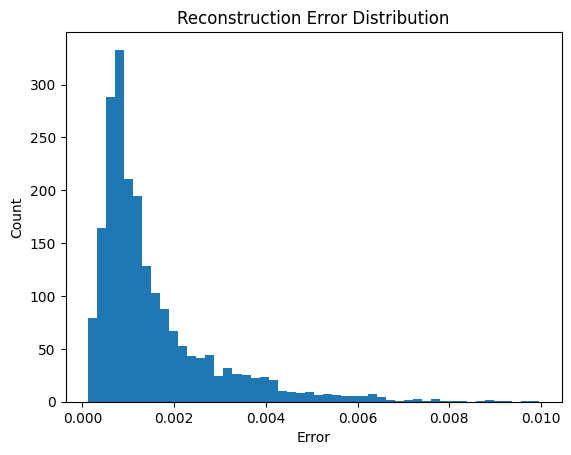

In [6]:
errors = get_reconstruction_errors(trained_model, X, device="cpu")

import matplotlib.pyplot as plt 

plt.hist(errors, bins=50)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

In [7]:
# Option 1: automatic (95th percentile)
# anomaly_mask, threshold = detect_anomalies(errors, quantile=0.95)

# Option 2: manual
anomaly_mask, threshold = detect_anomalies(errors, threshold=0.004)

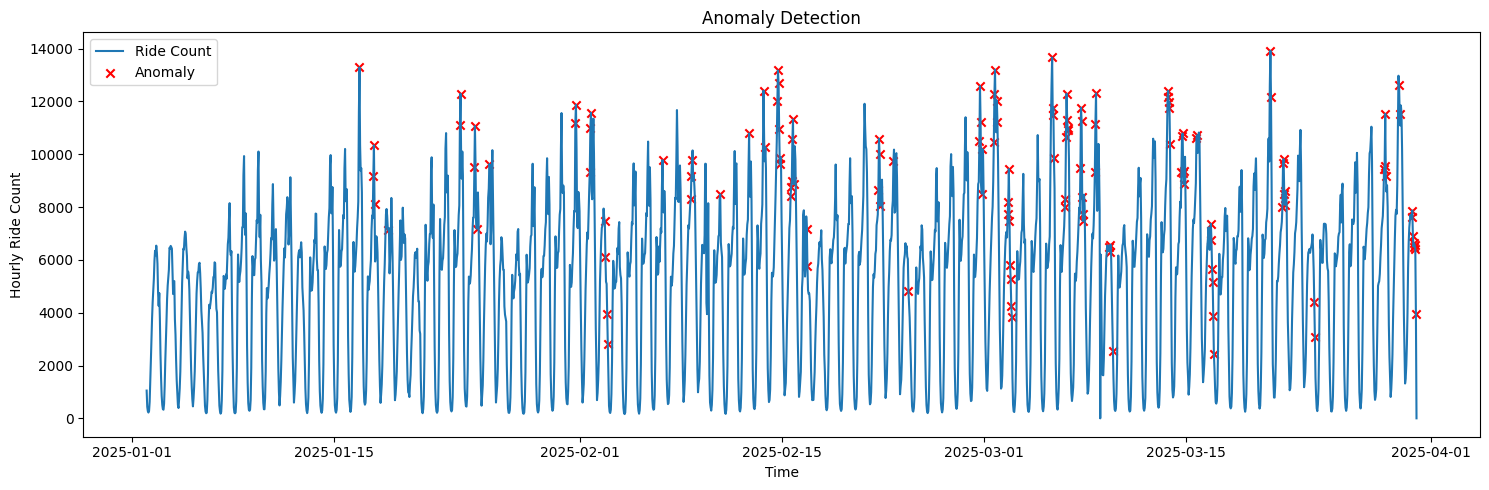

In [8]:
timestamps = ride_counts.index[window_size:]
values = ride_counts["ride_count"].values[window_size:]

plot_anomalies(timestamps, values, anomaly_mask)

In [9]:
import os
os.makedirs("results", exist_ok=True)

anomalies = timestamps[anomaly_mask]
anomalies.to_series().to_csv("../results/anomalies.csv", index=False, header=["timestamp"])

print(f"✅ Saved {len(anomalies)} anomalies to results/anomalies.csv")


✅ Saved 133 anomalies to results/anomalies.csv


The LSTM autoencoder successfully modeled normal NYC taxi traffic patterns and identified deviations based on reconstruction error.

Using a manual threshold of 0.004, we detected a focused set of high-error sequences that aligned with significant peaks, dips, and irregular ride volumes. These anomalies likely correspond to real-world disruptions such as storms, holidays, or city events.

This unsupervised approach provides a scalable method to surface rare or unusual behavior in transportation data without needing labeled events, and it can be extended to forecast future patterns, compare across zones, or integrate external features (e.g., weather, events) in future work.